
Finetuning Torchvision Models
=============================
[tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html) | [models](https://pytorch.org/vision/stable/models.html) | [datasets](https://pytorch.org/vision/stable/datasets.html)


transfer learning:  
[cs231n](https://cs231n.github.io/transfer-learning), [ruder.io](https://ruder.io/transfer-learning)

pytorch HowTo's:  
[save weights after training](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html)  
[load weights for inference](https://towardsdatascience.com/how-to-save-and-load-a-model-in-pytorch-with-a-complete-example-c2920e617dee)  
[use ADAM or ADAMW instead of SGD](https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/)  


TODO's:
* infer on test dataset and give some insights
* try > resolution 224 [discussion](https://discuss.pytorch.org/t/transfer-learning-usage-with-different-input-size/20744/6)


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os

%matplotlib inline

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


In [19]:
# Helper Functions
from libs.model_definitions import initialize_model
from libs.train_model import train_model

import libs.splitfolders as splitfolders

Settings
----------------

In [20]:
# data directory with [train, val, test] dirs
data_dir = "./dataset/topshots_split"

# train / val / test split
split_ratio = (.8, .1, .1)  
copy_dataset=True

# number of data loader workers
dloader_workers = 6

# Number of classes in the dataset
num_classes = 4   # TODO: len(image_datasets['train'].classes)


model_list =    ["resnet18", "resnet50", "alexnet", "vgg11_bn", "squeezenet", "densenet121", "inception_v3", "mobilenet_v2", 
                "mobilenet_v3_large", "regnet_y_16gf", "efficientnet_v2_s", "efficientnet_v2_m", "convnext_base", "swin_v2_b"]

model_name = "mobilenet_v3_large"

checkpoint_path = f"checkpoint/{model_name}.pt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 25

learning_rate = 1e-4

# train all layers or just head layer
train_deep = True

# ImageNet Constants
mean = [0.485, 0.456, 0.406] 
std =  [0.229, 0.224, 0.225]


# check if model_name exists
if not model_name in model_list:
    print(f"ERROR: model {model_name} unknown!")


### Split Dataset

In [ ]:
# check if dataset is already splitted
def check_existence(path, dirs=[]):
    for dir in dirs:
        if not os.path.isdir(os.path.join(path, dir)):
            return False
    return True

# copy or move dataset split into train, validation and test
if not check_existence(dirs=["val", "test", "train"]):

    split_data_dir = os.path.join(os.path.split(data_dir)[0], os.path.split(data_dir)[1]+"_split")

    splitfolders.ratio(data_dir, 
                       output=split_data_dir, 
                       seed=1337, ratio=split_ratio, 
                       group_prefix=None, 
                       move=not(copy_dataset))

data_dir = split_data_dir

Helper Functions
----------------






In [21]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, train_deep)

# print(model_ft)


Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [22]:
# Data augmentation and normalization for training
# http://pytorch.org/vision/main/transforms.html
# TODO: or use https://albumentations.ai instead

scale_range=(0.9, 1.1)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=scale_range),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),

    # Just normalization for validation
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=dloader_workers) for x in ['train', 'val']}


class_names = image_datasets['train'].classes

Initializing Datasets and Dataloaders...


In [23]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders_dict['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))

                img = inputs.cpu().data[j] / 2
                img = img.swapaxes(0, 1)
                img = img.swapaxes(1, 2)

                plt.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``train_deep=False`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [24]:
# Send the model to GPU if possible
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if not train_deep:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            #print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            continue

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)


Params to learn:


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




In [25]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, device=device)

Epoch 0/19
----------
train Loss: 1.1046 Acc: 0.5034
val Loss: 0.9606 Acc: 0.8056

Epoch 1/19
----------
train Loss: 0.5671 Acc: 0.8624
val Loss: 0.2152 Acc: 0.9722

Epoch 2/19
----------
train Loss: 0.2517 Acc: 0.9228
val Loss: 0.0852 Acc: 1.0000

Epoch 3/19
----------
train Loss: 0.2379 Acc: 0.9060
val Loss: 0.0598 Acc: 1.0000

Epoch 4/19
----------
train Loss: 0.2741 Acc: 0.8859
val Loss: 0.0447 Acc: 1.0000

Epoch 5/19
----------
train Loss: 0.1984 Acc: 0.9329
val Loss: 0.0237 Acc: 1.0000

Epoch 6/19
----------
train Loss: 0.2174 Acc: 0.9060
val Loss: 0.0525 Acc: 1.0000

Epoch 7/19
----------
train Loss: 0.2062 Acc: 0.9128
val Loss: 0.0393 Acc: 1.0000

Epoch 8/19
----------
train Loss: 0.1965 Acc: 0.9396
val Loss: 0.0195 Acc: 1.0000

Epoch 9/19
----------
train Loss: 0.1808 Acc: 0.9329
val Loss: 0.1697 Acc: 0.9167

Epoch 10/19
----------
train Loss: 0.1587 Acc: 0.9295
val Loss: 0.0504 Acc: 0.9722

Epoch 11/19
----------
train Loss: 0.1543 Acc: 0.9430
val Loss: 0.1918 Acc: 0.9444

Ep

In [26]:
print(float(hist[-1]))

1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


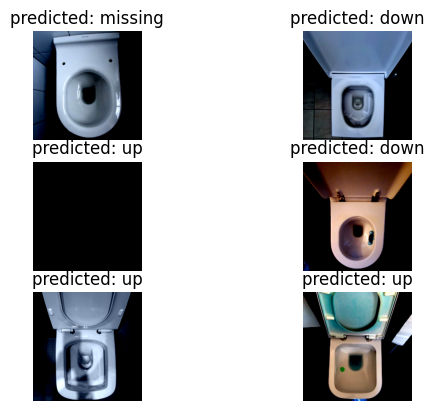

In [27]:
visualize_model(model_ft)

### Save Checkpoint
https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

https://stackoverflow.com/questions/42703500/how-do-i-save-a-trained-model-in-pytorch

In [28]:
# EPOCH = num_epochs  # TODO: current epoch / epoch of best val acc
# LOSS = 0.4          # TODO read from hist
#
# torch.save({
#             'epoch': EPOCH,
#             'model_state_dict': model_ft.state_dict(),
#             'optimizer_state_dict': optimizer_ft.state_dict(),
#             'loss': LOSS,
#             }, checkpoint_path)

torch.save(model_ft, checkpoint_path)

### Load Checkpoint

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# # Remember to first initialize the model and optimizer, then load the dictionary locally.
# model, input_size = initialize_model(model_name, num_classes, train_deep)
# model = model.to(torch.device(device))

# optimizer = optim.Adam(model.parameters(), lr=0.001)

# checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']


model = torch.load(checkpoint_path)
model = model.to(torch.device(device))

# set dropout and batch normalization layers to evaluation mode before running inference
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [30]:
# create data loader for test-data
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])
    
testset = datasets.ImageFolder(os.path.join(data_dir, "test"), test_transform)
test_loader = torch.utils.data.DataLoader(testset,batch_size = 64,shuffle=True)


test_acc = 0.0

for samples, labels in test_loader:
    with torch.no_grad():
        samples, labels = samples.to(device), labels.to(device)
        output = model(samples)

        # calculate accuracy
        pred = torch.argmax(output, dim=1)
        correct = pred.eq(labels)
        test_acc += torch.mean(correct.float())
        
print('Accuracy of the network on {} test images: {}%'.format(len(testset), round(test_acc.item()*100.0/len(test_loader), 2)))

Accuracy of the network on 40 test images: 92.5%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


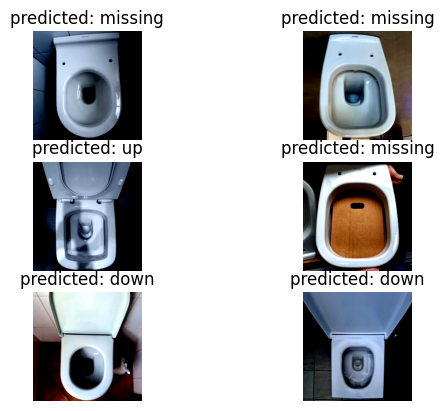

In [31]:
visualize_model(model)